[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/11_nb_imbalance_n_costs.ipynb) 

# Chapter 11 - Imbalanced and cost-sensitive learning
Welcome to chapter 11 of [Business Analytics and Data Science](). This week, we will revisit the lecture on imbalanced and cost-sensitive learning. Imbalance and asymmetric error costs occur frequently in business applications. Our well-known credit scoring use case exemplifies just this. Banks approve credit applications selectively and have achieved high sophistication in default prediction. Consequently, the observed default rates are often low, which implies that a credit scoring data set will typically exhibit class imbalance. Good customers represent the majority while defaulting clients represent the minority class. Using strategies from the realms of imbalanced learning, we can enhance the recognition of the minority class during *classifier training*. Apart from training, we have to ensure that the *evaluation* of a classifier (e.g., default prediction models) is based on suitable performance measures, which are robust toward class imbalance.

Similarly, it is a known fact in credit scoring that *error costs are asymmetric*. If we consider clients who would actually repay as the positive class, we can say that there are two possible errors in credit risk prediction:

- Accepting a client who will default (false positive, firm loses money lent)
- Rejecting a client who would have repaid (false negative, firm misses out on earning interests)

Just to elaborate on the meaning of false positive and false negative, if we thought our model predicted that someone would repay but that turns out to be wrong, it was false to categorize them in the positive class. That is a false positive. Then, if we reject someone who would have actually repaid, we were false about them being in the negative class. That is a false negative error.

In our scenario, the cost of a false positive error is equal to the part of the loan that is lost in case of default. On the other hand, a false negative error cost us the interest that we could have been earned. The false positive is an actual loss while the false negative is an opportunity cost. The literature on cost-sensitive learning has developed approaches to address asymmetric error costs during the *training* and/or the *evaluation* of a classifier. 

Note that this is just one example. Let's say we are developing a classifier which scans an medical image to check for the presence of a disease. Say we define the positive class to be when a disease is present. Accordingly, the negative class is associated with the absence of a disease. The possible errors are failing to detect the presence of the disease (false negative) or predicting someone to suffer the disease although this person is actually healthy (false positive). In a medical setting, it is not natural to think of the different errors to carry a different *cost*. However, you will agree that the false negative error is far more severe. The disease will go unnoticed with potentially hazardous consequences. While it is not nice to be diagnosed to suffer a disease, very likely a follow-up test would indicate that one is actually in good health. Therefore, the false positive error is less severe. Furthermore, if we extend the example and assume that the disease is rare, then it is also apparent that the example involves not only asymmetric error costs but also class imbalance. 

Time to explore some instruments for class imbalance and cost-sensitivity. Since the corresponding literature routinely considers classification, we will also stick to this form of predictive modeling. Thus, the tutorial will not touch on imbalance and cost-asymmetry in regression. 

The outline of the tutorial is as follows:
- Preliminaries
- Exploring the imbalance problem
- SMOTE from scratch
- Other imbalance learning techniques
- Cost sensitivity overview
- Thresholds with cost sensitivity
- Calibration curves
- MetaCost
- Class imbalance and cost-sensitivity with `sklearn`

# Preliminaries
We begin with the usual preparations. We will first use toy data and later move on to our usual HMEQ data set. The toy data generation code comes from a previous tutorial. We have adjusted the corresponding function so that it facilitates controlling the number of observations per class. This way, we can see how our prediction quality changes as class imbalance increases or decreases.

In [1]:
# Import standard packages. 
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors

# Select random state to make results reproducable for sklearn functions
import random
rnd_state = 888
random.seed(a=rnd_state) 

import warnings # The imblearn package uses functions that have a future deprecation warning for sklearn (we can ignore these)

In [2]:
def toy_data(n_1=1000, n_2=100, mu1=[1, 1], mu2=[2,2], sig1=1, sig2=1):
    """ Custom function to generate linearly seperable toy data. The code has been discussed in more detail in Tutorial #3.
        
        The arguments represent, respectively, the size of the data, the mean vectors of the two Gaussians from which we
        sample class 1 and class 2 data points, and their standard deviations. The code has been modified, n_1 is now the 
        amount of class 1 samples, and n_2 is the amount of class 2 samples to produce.
    """
    
    class1_x1 = np.random.normal(loc=mu1[0], scale=sig1, size=n_1)
    class1_x2 = np.random.normal(loc=mu1[1], scale=sig1, size=n_1)

    class2_x1 = np.random.normal(loc=mu2[0], scale=sig2, size=n_2)
    class2_x2 = np.random.normal(loc=mu2[1], scale=sig2, size=n_2)

    y1 = np.repeat(0, n_1)
    y2 = np.repeat(1, n_2)

    class1 = np.vstack((class1_x1, class1_x2)).T
    class2 = np.vstack((class2_x1, class2_x2)).T

    X = np.vstack((class1, class2))
    y = np.concatenate((y1, y2))
    
    return X, y

In [3]:
# Create and plot the data
X, y = toy_data()

# Always useful to remind oneself of the dimensions of a data set
print("Shape of X {}".format(X.shape))  
print("Shape of y {}".format(y.shape))

Shape of X (1100, 2)
Shape of y (1100,)


In [4]:
 np.unique(y, return_counts=True)

(array([0, 1]), array([1000,  100], dtype=int64))

# Imbalanced learning
Let's first examine the common situation in which is there are few instances for at least one of your classes. This can have some serious effects on your model's performance as it's often the minority class which we are interested in. It also forces us to think about alternative performance metrics because, as we are about to demonstrate, traditional metrics may be misleading.

## Misleading metrics
We have made the point in the lecture that one problem of class imbalance related to the fact that standard indicators of classification performance provide misleading signals when the data is imbalanced. Let's start by demonstrating the issue with a little experiment. 

### Imbalance ratio and intervention threshold 

When you first receive a classification problem, it is a good idea to check if there is class imbalance. You can do this by applying the `value_counts()` function to your dependent variable. You can also use the NumPy function `unique()`. We illustrate both throughout the tutorial. Further possibilities exist as well. 

A difficult question is at what point you should remedy class imbalance. For example, if the ratio between classes is 1:10, should you take action? Is it okay to have an imbalance of 2:3? There is not clear-cut answer to these questions. The costs of getting the minority class right play a role but so do many other factors. Often, the best approach is to test empirically whether remedying class imbalance improves your results. For example, train your model once on the original (i.e., imbalanced) data set and measure its performance on the test set. Repeat the process but this time address the imbalance *in the training set*. Predicting the same test set facilitates comparing whether your performance is better with or without addressing the imbalance. 
**Important** never address imbalance in the test set. The purpose of the test set is to represent a real-world application of your model. In the real-world, the classes will be imbalanced. Therefore, it is fundamentally wrong to resample the test data. 

If you think about it, the necessity to never change the class distribution in the test set implies that using cross-validation together with strategies to address class imbalance is a little complicated. 

Let's illustrate the consequences of class imbalance using synthetic data. First, we specify a range of imbalance ratios (more specifically, we fix the number of minority class cases). Then, we iterate over each setting, train a logit classifier and apply this classifier to a test set. This chain will give as an idea of how sensitive logit reacts to class imbalance. 


In [6]:
# Set up a range of possible numbers of the minority class
minority_num = np.arange(10, 1000, 10)

# Initialize empty list of metrics
acc_list = []
tpr_list = []
auc_list = []

# Incrementally decrease class imbalance and record metrics
for num in minority_num:
  X, y = toy_data(n_1=2000-num, n_2=num) # Keep total observations fixed at 2000
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 888)  # 30% as test set
  clf = LogisticRegressionCV(cv=5, random_state=rnd_state).fit(X_train, y_train)  # Using Logit with CV for more stable results
  y_pred = clf.predict(X_test)
  
  # Log total accuracy
  acc = metrics.accuracy_score(y_test, y_pred)
  acc_list.append(acc)
  
  # Log AUC and TPR
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
  auc = metrics.auc(fpr, tpr)
  auc_list.append(auc)
  tpr_list.append(tpr[1])

### Accuracy: problematic metric with class imbalance
Let's first take a look at overall accuracy and notice how **total accuracy decreases as imbalance gets less severe**. This is because if the imbalance is very large, the machine does not need to carefully learn the minority class and predicts only one class. Since 1 observation of the minority class is weighted just as heavily as an observation of the majority class, if the objective for the algorithm is to get most correct as possible, it might as well just predict the majority class. Well, you know that the training of a logit classifier actually minimizes the negative log-likelihood function and not classification error but the same argumentation holds because the few minority class cases do not exert a large influence on the negative log-likelihood function. The main problem is that always predicing a value of zero (e.g., label of the majority class) achieves a low classification error and also a low (i.e., good) objective value.

However, as the imbalance ratio gets closer to 1:1, the model must learn the minority class better and makes more mistakes overall in the final prediction. **In essence, total accuracy is a misleading metric if there is a class imbalance.** Again, let's think of a model which detects a disease from a medical image. If only 5% of cases are true positives but the model labels everything as negative, the model will achieve 95% accuracy. In this case, our model fails at its purpose even though its accuracy is very high.


The following chart depicts the development of classifcation accuracy over the different imbalance ratios.

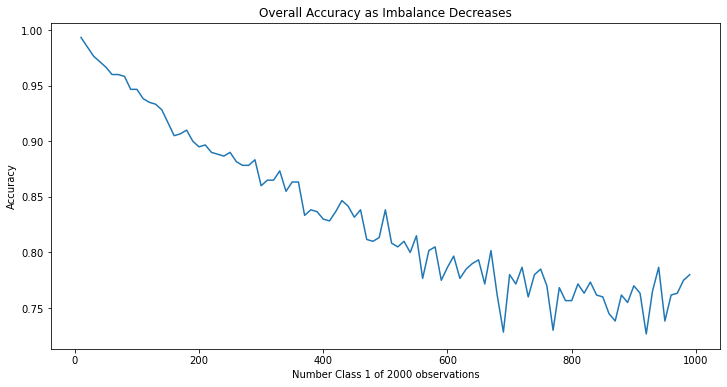

In [7]:
plt.plot(minority_num, acc_list)
plt.title('Overall Accuracy as Imbalance Decreases')
plt.xlabel('Number Class 1 of 2000 observations')
plt.ylabel('Accuracy');

### AUC: sensitive to positive class
Now let's take a look at an alternative metric, the AUC. When we set the minority class to be the positive class, we see that the AUC increases when class imbalance reduces. This agrees with our intuition that imbalance complicates classifier training. Remember that the AUC is calculated with sensitivity (TPR) and 1-specificity (FPR).  Intuitively, we want a metric that does increase as the model is able to classify both cases correctly, so AUC demonstrates itself here as a more appropriate metric when classes are imbalanced. 

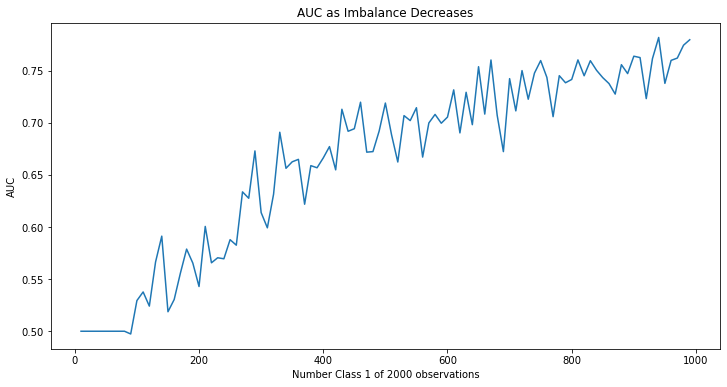

In [8]:
plt.plot(minority_num, auc_list)
plt.title('AUC as Imbalance Decreases')
plt.xlabel('Number Class 1 of 2000 observations')
plt.ylabel('AUC');

### Sensitivity (true positive rate or recall)
Note that our above explanation assumes that the minority class is defined as  the 'positive' class. This is common in imbalanced learning scenarios.

We can also zoom in on the minority class and focus on if it was accurately predicted. Sensitivity (aka true positive rate or recall) is an example of such a metric. It is calculated by evaluating: Number of True Positive / (Number of True Positive + Number of False Negative). In words, it is the number of correctly classified minority class samples over all minority class samples.

As we can see in the graph below, there is a lot of volatility in the graph at the beginning when there are few of the minority class to begin with. As the number in the minority class grows, we see that the TPR shows growth as well.

You could also consider the use of a metric like the G-Mean:

$$ \sqrt{\frac{TP}{TP+FN} \cdot  \frac{TN}{TN+FP}} $$

Or the F-measure ( $ \beta $ is a weight to adjust):

$$ \sqrt{\frac{(1+\beta)^2 \cdot \text{Recall} \cdot \text{Precision}} {\text{Recall} \cdot \text{Precision}}} $$

These metrics evaluate the efficacy of the model to classify both classes. Create charts like the one above/below for the G-mean and the F-measure as a little exercise. 


Text(0, 0.5, 'Sensitivity')

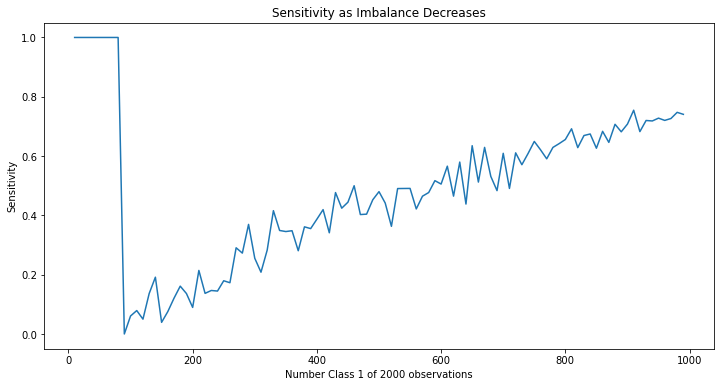

In [9]:
plt.plot(minority_num, tpr_list)
plt.title('Sensitivity as Imbalance Decreases')
plt.xlabel('Number Class 1 of 2000 observations')
plt.ylabel('Sensitivity')

### Remedying class imbalance via resampling
We introduced *resampling* as one model-agnostic way to address class imbalance. The function of simple under/oversampling is trivial. So let us focus on slightly more sophisticated resampling techniques. The *SMOTE* algorithm is clearly one of the best-known strategies. It is widely used in the industry and considered as a benchmark approach to new imbalanced learners in virtually any academic paper. So, let's take a deep-dive into SMOTE.

Let's switch over to our HMEQ dataset in order to do this.

In [10]:
# Load the data for this tutorial directly from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv'

df = pd.read_csv(data_url, index_col='index')

# Extract target variable and feature matrix 
X = df.drop(['BAD'], axis=1) 
y = df[['BAD']].values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = rnd_state)  # 30% of the data as hold-out

# Make yourself familiar with these vectors
print('Shape of the data ', y_train.shape, X_train.shape, y_test.shape, X_test.shape)

Shape of the data  (4172, 1) (4172, 18) (1788, 1) (1788, 18)


In [12]:
 # Check data imbalance to reveal a ratio of approx 4:1
df.BAD.value_counts()

False    4771
True     1189
Name: BAD, dtype: int64

## SMOTE from scratch

SMOTE or Synthetic Minority Oversampling Technique finds two examples of the minority class which are close in the feature space. SMOTE then places a newly generated sample with a minority class label in between the two examples. Remember that with most other forms of data manipulation, you want to perform this step only on the training data after the data has been split. This ensures that the test set remains as similar to regular data as possible.

This version of SMOTE will be slightly simpler. Instead of finding a place in the hyperplane between existing observations, it finds the 5 nearest neighbors then uses those nearest neighors' feature values as potential values for respective features of the newly generated sample. This code is inspired by the following [medium article by Breya Walker](https://medium.com/@breya.heysoftware/synthetic-minority-over-sampling-technique-smote-from-scratch-e1167f788434). We make use of object-oriented programming, which is good practice. We have seen this approach in action before. It is useful to get used to it. 

### Custom class smote

In [13]:
class smote:

    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.data_head = df.head()

    def check_imbalance(self, verbose=True):
        (vals, val_counts) = np.unique(self.target, return_counts=True)
        assert val_counts.size == 2, 'Target must be binary'
        diff = max(val_counts) - min(val_counts)
        min_class = vals[np.argmin(val_counts)]
        imb_ratio = max(val_counts) / min(val_counts)
        if verbose:
            print ('There are ', max(val_counts),
                   ' in the majority class and ', min(val_counts), ' in the minority class.')
            print ('The imbalance ratio is', imb_ratio)
            print ('The minority class has the label', min_class)
        return (diff, min_class)  # returns minority class label and difference in size between classes

    def isolate_minority(self):
        diff, min_class = self.check_imbalance(verbose=False)
        min_index, _ = np.where(self.target == min_class)
        data_min = self.data.iloc[min_index, :].copy()
        return data_min  # returns df of only the minority class

    def minority_nearest_neighbor(self):
        data_min = self.isolate_minority()

        nbs = NearestNeighbors(n_neighbors=5, metric='euclidean',
                               algorithm='kd_tree').fit(data_min)
        (distance, neighbors) = nbs.kneighbors(data_min)
        return neighbors

    def generate_minority_samples(self):
        data_min = self.isolate_minority()
        npdata_min = np.array(data_min)

        neighbors = self.minority_nearest_neighbor()

        generated_samples = []

        for neighbor in range(len(neighbors)):
            neighbor_data = npdata_min[neighbors[neighbor]]  # Put neighbor data for each sample in a df
            neighbor_data = pd.DataFrame(neighbor_data)
            generated_samples.append([])

            for col in range(len(neighbor_data.columns)):
                # Generate new sample by randomly choosing feature value from neighbors
                generated_samples[neighbor].append(random.choice(neighbor_data[col]))  

        return generated_samples

    def fix_imbalance(self):
        (diff, min_class) = self.check_imbalance(verbose=False)
        neighbors = self.minority_nearest_neighbor()

        data_min = self.isolate_minority()
        npdata_min = np.array(data_min)

        # Find rough number of times to generate new samples by dividing difference by minority class size

        repeat_num = round(diff / data_min.shape[0])

        generated_samples = []

        # Repeat data generation for the number of repeat times

        for i in range(1, repeat_num):
            new_sample = self.generate_minority_samples()
            generated_samples = generated_samples + new_sample

        # Prepare new index to newly generated samples

        max_data_ind = max(self.data.index)
        final_max = max_data_ind + len(generated_samples)
        new_ind = np.arange(max_data_ind, final_max)

        # Create new dataframe with generated samples

        generated_samples = pd.DataFrame(generated_samples,
                columns=X_train.columns, index=new_ind + 1)
        generated_samples.drop_duplicates(keep='first', inplace=True)

        # Join new samples with original data

        new_data = pd.concat([self.data, generated_samples])

        # Generate y with correct length

        new_target = np.append(self.target, np.ones([1, generated_samples.shape[0]]))

        return (new_data, new_target)

In [14]:
# Generate the smote object and then fix the imbalance in the data
smote = smote(data=X_train, target=y_train)
X_train_smote, y_train_smote = smote.fix_imbalance()

### Reference classifier trained from the original data

In [15]:
# Fit a model with the regular data as the reference model for comparison

clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True).fit(X_train, np.ravel(y_train))
y_pred = clf.predict(X_test)
  
acc = metrics.accuracy_score(y_test, y_pred)
  
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The total accuracy is {:.2f}'.format(acc))
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

The total accuracy is 0.84
The model predicted the minority class 8.84 % of the time
The AUC is 0.64
The sensitivity for the model is 0.31


### Classifier after addressing class skew using SMOTE

In [16]:
# Fit a regression with rebalanced data
clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True).fit(X_train_smote, y_train_smote)
y_pred = clf.predict(X_test)
  
acc_smote = metrics.accuracy_score(y_test, y_pred)
  
fpr_smote, tpr_smote, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc_smote = metrics.auc(fpr_smote, tpr_smote)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The total accuracy is {:.2f}'.format(acc_smote))
print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc_smote))
print('The sensitivity for the model is {:.2f}'.format(tpr_smote[1]))

The total accuracy is 0.78
The model predicted the minority class 25.73 % of the time
The AUC is 0.71
The sensitivity for the model is 0.60


We can see that overall, accuracy lowered which was expected. The naive model predicts the minority class 3x less than the model which is rebalanced by our version of SMOTE. We also see that the AUC and sensitivity both increase thanks to rebalancing. Through these metrics, it is clear that addressing the imbalance problem clearly has affected the classifier's performance. In this case, the net effect was positive. SMOTE facilitates getting a better result in terms of the AUC, which we established to be the more suitable metric.

## Libraries for imbalanced learning

Now let's take a look at the options available to you through the libraries that exist. One of the most useful libraries for dealing with imbalanced data sets is `imblearn` whose documentation you can view [here](https://imbalanced-learn.org/stable/user_guide.html).

We will continue to use the HMEQ data set for this. We have already shown that the sensitivity increases quite a bit once we implement some measure to fix the imbalance. Note that overall accuracy decreases are again normal when the classifier is trained on highly imbalanced data (it will classify everything as the majority class and most predictions will be correct). 


### Undersampling

One option for fixing our imbalanced data is to take less observations from the majority class so that the number observations in each class are equal. This is called undersampling. This should be done with caution as we will be discarding quite a lot of observations if there is a heavy imbalance. Ignoring these observations could cause the model to lose quite a lot of information.

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=rnd_state,
                         sampling_strategy='majority')
(X_resampled, y_resampled) = rus.fit_resample(X_train, y_train)

clf = LogisticRegressionCV(cv=5, random_state=rnd_state,
                           fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))
y_pred = clf.predict(X_test)

acc = metrics.accuracy_score(y_test, y_pred)

(fpr, tpr, thresholds) = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

warnings.simplefilter(action='ignore', category=FutureWarning)

The model predicted the minority class 34.51 % of the time
The AUC is 0.71
The sensitivity for the model is 0.69


### Oversampling

Instead of drawing less observations from the majority class, we could instead reduplicate instances of the minority class. If draw these minority observations multiple times at random, this is called random oversampling. This method of correcting imbalance works since there is now a larger penalty for getting minority class instances wrong (as there are simply more of them in the dataset). However, it must be used with caution as it can cause overfitting since it does not explore the potential feature space of the minority class any further.

In [19]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=rnd_state, sampling_strategy='minority')
X_resampled, y_resampled = ros.fit_resample(X_train, np.ravel(y_train))

clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))
y_pred = clf.predict(X_test)
  
acc = metrics.accuracy_score(y_test, y_pred)
  
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

warnings.simplefilter(action='ignore', category=FutureWarning)

The model predicted the minority class 32.21 % of the time
The AUC is 0.73
The sensitivity for the model is 0.69


### SMOTE
Let's now try SMOTE using `imblearn`. This algorithm is more complex than the algorithm that was created above by scratch so it should perform pretty well in comparison. Normally SMOTE will find a point in between two close samples of the minority class and generate a new minority class sample there. We can see that this is quite successful as well as random over- and undersampling.


In [20]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, np.ravel(y_train))

clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))
y_pred = clf.predict(X_test)
  
acc = metrics.accuracy_score(y_test, y_pred)
  
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

warnings.simplefilter(action='ignore', category=FutureWarning)

The model predicted the minority class 35.63 % of the time
The AUC is 0.71
The sensitivity for the model is 0.69


### Borderline SMOTE
One potential drawback of SMOTE is that it can select instances which are outliers in the minority class. In the worst case scenario, this can generate minority class samples which add to these outliers and mislead the algorithm into classifying samples nearby as minority samples when they should be clasisfied as majority class samples. This is fixed by borderline SMOTE which does not perform SMOTE on any points wihch are too close to the border between the majority class and the minority class. We can see that neither the AUC nor sensitivity changed for our scenario, so it may not be the best choice in this case. However, you should take a look at the other options for SMOTE and test them out to see if they perform better in your situation.

In [21]:
from imblearn.over_sampling import BorderlineSMOTE

X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X_train, np.ravel(y_train))

clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True).fit(X_resampled, np.ravel(y_resampled))
y_pred = clf.predict(X_test)
  
acc = metrics.accuracy_score(y_test, y_pred)
  
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

min_freq = y_pred.sum()/len(y_pred) * 100

print('The model predicted the minority class {:.2f}'.format(min_freq), '% of the time')
print('The AUC is {:.2f}'.format(auc))
print('The sensitivity for the model is {:.2f}'.format(tpr[1]))

warnings.simplefilter(action='ignore', category=FutureWarning)

The model predicted the minority class 36.69 % of the time
The AUC is 0.71
The sensitivity for the model is 0.70


These are some of the major ways to deal with class imbalance, however there are other functions in this library which can help you achieve your goal. You can explore more ways to deal with resampling techniques by going through the [documentation](https://imbalanced-learn.org/stable/user_guide.html) of `imblearn`. However, resampling techniques are just one way to deal with this problem. We can also consider the idea of incorporating more penalties for misclassifying the minority class which we will explore next. Finally, note the resampling is no silver bullet and will not always facilitate better results than using the original data. We have used the logit model for the above demonstration. 

It would be a good exercise to play around with the `imblearn` library and test whether you can also improve other classifiers like Random Forest or XGB. 
*Spoiler alert*: you will not get good results. Both RF and XGB work well for the HMEQ data set. Resampling does not get you much further. However, if you are in the mood for practice, you could artificially reduce the number of minority class examples in the HMEQ data set and check whether a (much) more severe imbalance leads to, e.g., SMOTE + XGB working better than XGB alone. All code that this needs is available above, so we leave this experiment for you.

# Cost-sensitive learning
Class imbalance and cost-sensitive learning are often connected. For example, one approach to imbalance learning is to consider errors among minority class cases more costly than error among majority class cases. Then, we can use cost-sensitive learning methods for training a classifier on an imbalanced data set. If resampling is the maybe most prevailing approach to address class imbalance, using a cost-sensitve learner is probably the second most widely used approach. 

In real-world application, asymmetric error costs and imbalance often go hand in hand. The interesting class, which we aim to detect, is often a minority and making an error in recognizing this class is often associated with higher costs compared to misclassifying a majority class case. The examples we discussed above, credit scoring and medical data analysis, both represent this situation. 

Before we continue with cost-sensitive learning, note that the following explanations make use of concepts like false positive (FP), false negatives (FN), true positives (TP) and true negatives (TN). **Always bear in mind that the meaning of those acronyms depends on how you define the classes.** In the case of the HMEQ data set, we next consider the defaulting clients as members of the negative class. This choice is however arbitrary. 

In the lecture, we have discussed the link between cost-sensitive learning and the cost-matrix. Recall that we derive the cost-matrix from the corresponding cost-benefit matrix. We do this by assuming, without loss of generality, that the cost for correct classifications is zero. Furthermore, it is important to note that a cost-matrix does not have to contain the actual cost of wrong predictions, but the ratio. There are several ways to compute such a cost-matrix. In a real world setting, you would hope to establish the cost-matrix with domain knowledge and, ideally, data-based information.

For this data set, we assume that the cost of a false positive prediction is the loss of the complete value of the loan. This is an assumption we make for simplicity. Furthermore, the cost of a false negative prediction is the loss of interest we would have made on the loan if we did not decline the loan application. When converting the data accordingly, we come to an average ratio of roughly 1:32 (FN:FP). This means that one false positive prediction (giving a loan to a person who will default) costs the bank the same amount as making 32 false negative predictions (not giving a loan to a person, who would have not defaulted). We implement these numbers for our cost-matrix as shown by [Elkan (2001)](http://web.cs.iastate.edu/~honavar/elkan.pdf):


In [22]:
# Data analysis terms for each quadrant

pd.DataFrame({'actual_GOOD(0)': ['TP', 'FN'], 'actual_BAD(1)': ['FP', 'TN']}, index= ['predicted_GOOD(0)', 'predicted_BAD(1)']) 

,actual_GOOD(0),actual_BAD(1)
predicted_GOOD(0),TP,FP
predicted_BAD(1),FN,TN


In [23]:
# Costs associated for each quadrant

pd.DataFrame({'actual_GOOD(0)': ['C(g,G)', 'C(b,G)'], 'actual_BAD(1)': ['C(g,B)', 'C(b,B)']}, index= ['predicted_GOOD(0)', 'predicted_BAD(1)'])

,actual_GOOD(0),actual_BAD(1)
predicted_GOOD(0),"C(g,G)","C(g,B)"
predicted_BAD(1),"C(b,G)","C(b,B)"


In [24]:
# Cost matrix for our scenario (project-specific)

cost_matrix = pd.DataFrame({'actual_GOOD(0)': [0, 1], 'actual_BAD(1)': [32, 0]}, index= ['predicted_GOOD(0)', 'predicted_BAD(1)'])
cost_matrix

,actual_GOOD(0),actual_BAD(1)
predicted_GOOD(0),0,32
predicted_BAD(1),1,0


## Cost-minimal threshold

Recall the following equation to define the cost-minimal cutoff:

$$ 𝑝(𝑏|𝒙) ≥ 𝜏^∗ =  \frac{𝐶(𝑏,𝐺)}{ 𝐶 (𝑏,𝐺) + 𝐶(𝑔,𝐵)} $$

Using the above stated cost-matrix, the optimal cutoff for our specific matrix is:

$$ 𝑝(𝑏|𝒙) ≥ 𝜏^∗ =  \frac{1}{ 32+1} $$

Let's calculate this threshold:

In [25]:
# Bayes optimal threshold
threshold_bayes = (cost_matrix.iloc[1,0]               # C(b,G)
                   /(cost_matrix.iloc[1,0]             # C(b,G)
                     +cost_matrix.iloc[0,1])).round(5) # C(g,B)
threshold_bayes

0.0303

Now that we have defined this cutoff, we need to establish the corresponding class predictions. For comparison, we will also calculate the class predictions of the default cutoff: 0.5. 

In [26]:
# Train a model and get probaility predictions
clf = LogisticRegression(penalty='none', fit_intercept=True).fit(X_train, y_train.ravel())
pred_proba = clf.predict_proba(X_test)[:,1]

# Use the array above to manually determine the cut-off and convert to class predictions
pred_default = np.where(pred_proba >= 0.5, 1, 0) # 0.5 is the default cut-off, equivalant to y_pred from above
pred_bayes= np.where(pred_proba >= threshold_bayes, 1, 0) # Using the cut-off defined by the cost-minimal threshold function
print(np.mean(pred_default), np.mean(pred_bayes)) # Shows the percentage of observations that are now predicted with the label 1, default

0.0883668903803132 0.9457494407158836


## Evaluating cost-sensitive classifiers
It is important understand that for cost-sensitive classifiers, the methods we have learnt so far do not suffice. This part of the tutorial will elaborate on the limitations of our usual model evaluation techniques for cost-sensitive scenarios like ours and propose a different method to quantify the performance of cost-sensitive methods.

As we are working with distinct class predictions, a ROC curve is not an option, as this compares the true positive and true negative rate over all cutoffs. This means, we could work with accuracy, sensitivity and specificity. 
Let's see how the different cut-offs perform in terms of accuracy:

In [27]:
from sklearn.metrics import accuracy_score
print("The accuracy of the model using the default cutoff is: {}".format(accuracy_score(y_test, pred_default)))
print("The accuracy of the model using the cost-minimal cutoff is: {}".format(accuracy_score(y_test, pred_bayes)))

The accuracy of the model using the default cutoff is: 0.8361297539149888
The accuracy of the model using the cost-minimal cutoff is: 0.25279642058165547


The accuracy for the cost-minimal cutoff is only about 20%. While usually we would reject this model, we will find that this cutoff is an improvement to the default cutoff. We can also visualize the cutoffs on the ROC curve to give you a better idea of the specificity and sensitivity of the different cutoffs. For this, we use a function from a solution to excercise 6. Here we calculate the corresponding FPR and TPR for a specific cutoff.

In [28]:
# Calculating fpr and tpr manually at a given cutoff
# We will use this function to plot markers at distinct point across our line graph to see where the different cutoffs are along the graph
def tpr_fpr_calc(cutoff, yhat_prob, y_true):

    # temp variable giving distinct predictions based on the cutoff given as an input
    temp = (yhat_prob >= cutoff).astype(bool)

    # Create confusion matrix for this prediction
    cmat = metrics.confusion_matrix(y_true, temp)
    
    # Calculate FPR
    fpr = cmat[0,1] / (cmat[0,1] + cmat[0,0])

    # Calculate TPR
    tpr = cmat[1,1] / (cmat[1,1] + cmat[1,0])

    return tpr, fpr

In [29]:
# Calculate all FPRs and TPRs for the LogitCV model
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba, pos_label=1)

# Calculate TPR and FPR for both cutoffs
tpr_bayes, fpr_bayes = tpr_fpr_calc(threshold_bayes, pred_proba, y_test)
tpr_default, fpr_default = tpr_fpr_calc(0.5, pred_proba, y_test)

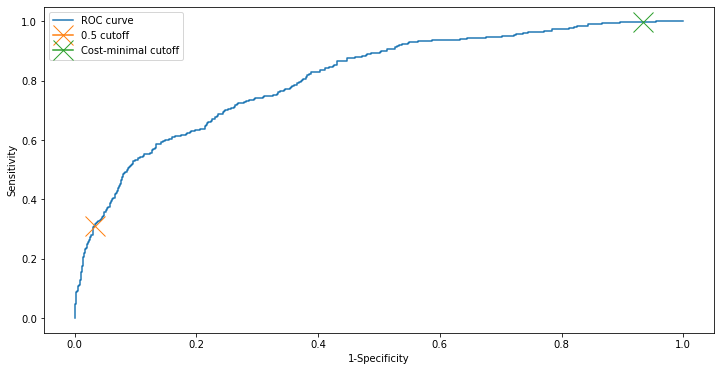

In [30]:
# Plot ROC curve and mark cutoffs on the curve
plt.plot(fpr, tpr, label = "ROC curve")
plt.plot(fpr_default, tpr_default, marker="x", markersize=20, label ="0.5 cutoff")
plt.plot(fpr_bayes, tpr_bayes, marker="x", markersize=20,  label ="Cost-minimal cutoff")
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.legend();

From the knowledge you have obtained in this class so far, you would say that the cutoff we calculated does not result in a good model. However, looking at the ROC curve, we can already gain more insight. 

Recall that sensitivity is the proportion of correctly identified positives (BAD) and specificity is the proportion of correctly identified negatives(GOOD). Since we have a ratio of 32:1 of misclassifying positives to negatives, it seems reasonable to prefer a much higher sensitivity.

For the default cutoff, both specificity and sensitivity are around 0.7. Howver, the Bayes minimal cutoff shows a much higher sensitivity than specificity. This means, it is more sensitive towards correctly classifying observations of the positive class (BAD) than the regular cutoff. At the same time, the specificity is very low. From other ROC plots, we know that this is usual for cutoffs with a high sensitivity (top right corner of the plot). It also makes sense when you look at the respective cost of misclassification.

Remember that **if the bank accepts 1 application from a future defaulter, this is equivalent of rejecting 32 trustworthy applicants**. Banks would therefore be ready to reject quite a few trustworthy applicants to avoid a single default. This now leads us to how we evaluate cost-sensitive models. Recall, we calculated the **cost-minimal cutoff**. This means, we have to calculate the corresponding error cost to determine which model provides the better outcome for the bank.

Before we can calculate the error cost, we need to adjust our cost matrix to allow for multiplication with the confusion matrix. 

*Please note that we have to transpose the cost matrix to be able to multiply both matrices with each other. This is because we set up the cost-matrix following the paper [Elkan (2001)](http://web.cs.iastate.edu/~honavar/elkan.pdf). When calculating the confusion matrix in Python, however, the "actuals" and "predictions" are reversed. This is another reminder to always make sure to read the labels, as to avoid confusion. See here:*

In [31]:
cost_matrix # Note that the columns and rows have been switched with the sklearn function below

,actual_GOOD(0),actual_BAD(1)
predicted_GOOD(0),0,32
predicted_BAD(1),1,0


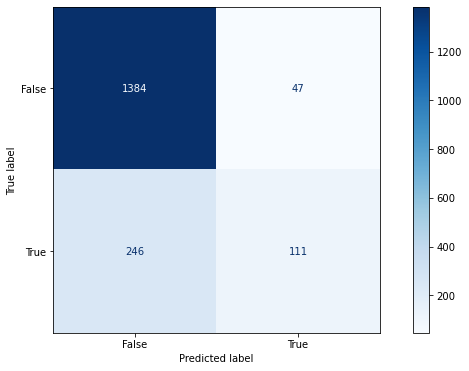

In [32]:
from sklearn import metrics 
metrics.plot_confusion_matrix(clf, X_test, y_test,  cmap=plt.cm.Blues, values_format='d') # Columns and rows have been transposed compared to above

Since this way we cannot perfectly match each cell with the corresponding field in the cost-matrix, we transpose the matrix and then multiply both matrices with each other. Afterwards, we will calculate the corresponding error cost. For this, we have to calculate the confusion matrix for the class predictions. To make the results comparable, no matter for how many observations we calculate this error, we compute the probabilities for FN, FP, TP and TN in the confusion matrix by dividing each cell by the number of observations in the test data. 


In [33]:
# To calculate the error cost, we need to convert our predictions into the same format as the cost-matrix
cmat_default = metrics.confusion_matrix(y_test, pred_default)
cmat_bayes = metrics.confusion_matrix(y_test, pred_bayes)

# Calculate confusion matrix probabilities for each cell and multiply with cost-matrix to calculate the cost
print("The error cost for the default cutoff is: {}".format(np.sum(np.sum((cmat_default/len(y_test))*cost_matrix.T)))) # summarize to get total cost
print("The error cost for the cost-minimal cutoff is: {}".format(np.sum(np.sum((cmat_bayes/len(y_test))*cost_matrix.T))))

The error cost for the default cutoff is: 4.428970917225951
The error cost for the cost-minimal cutoff is: 0.7645413870246085


By multiplying the confusion matrix probabilities with the corresponding cell in the cost-matrix and summarizing the results, we obtain the cost related to each model. It shows why a bank would chose the cost-minimal cutoff over the default cutoff. **While we only obtained a 20% accuracy for this threshold, the default model incurs almost 3x the cost.** This also underlines why traditional evaluation metrics might not always be sufficient and the context of predictions is very important when analyzing the efficiency of a model.

So we can calculate the error-cost of other cost-sensitive methods later, we save this process as a function.

In [34]:
# Save function to calculate error-cost including option to adjust cutoff
def calc_error_cost(y_probabilities, y_test, cutoff, cost_matrix_df):
    pred = np.where(y_probabilities >= cutoff, 1, 0)                    # convert class probabilities into class predictions
    cmat = metrics.confusion_matrix(y_test, pred)                       # compute corresponding confusion matrix
    cost = (np.sum(np.sum((cmat/len(y_test))*cost_matrix.T))).round(5)  # calculate the corresponding cost
    return [cutoff, cost]

In [35]:
# Save the results for the method comparison at the end
cutoff_cost_default = calc_error_cost(pred_proba, y_test, 0.5, cost_matrix)
cutoff_cost_bayes= calc_error_cost(pred_proba, y_test, threshold_bayes, cost_matrix)

## Empirical Thresholding

The methods proposed by [Elkan (2001)](http://web.cs.iastate.edu/~honavar/elkan.pdf) is a theoretical approach. Another approach is to empirically tune the threshold. This means finding the threshold that gives the lowest error cost based on the given cost-matrix and data. This is similar to us searching for the cutoff with the highest accuracy score in excerice 6, just with a different intention. This time, we do not want the most accurate cutoff but the most cost-efficient cutoff. While this is a good approach, empirical tuning may be prone to overfitting as you base it on the same data set. Because of that, we use a cross-validation approach and average over all cutoffs with the lowest error-cost for each fold. Let's start by defining this function:

In [36]:
# To use cross-validation we refer back to this function we defined in the model assessment tutorial
from sklearn.utils import shuffle
def cv_split(seq, splits):
  return (seq[i::splits] for i in range(splits))

# Define function for threshold tuning
def lowest_error_cutoff(k, X_train_df, X_test_df, y_train_true, y_test_true, bayes_cost_matrix, y_test_probabilities):
  cutoffs_total = [] # save best cutoff from each split here, so we can average this cutoff later

  # Create a list of the index of our full data set as input, and k for the amount of splits
  cv_split_list = list(cv_split(shuffle(X_train_df.index.values.tolist(), random_state=888), k)) 

  for fold, i in enumerate(cv_split_list): # for each split 

    temp = X_train_df.index.isin(i) # Create temp variable for data to exclude            
    X_train_cv, y_train_cv = X_train_df.iloc[~temp], y_train_true[~temp] # Build model on all but hold out data
    X_test_cv, y_test_cv =  X_train_df.iloc[temp], y_train_true[temp] # Test on hold out data later
    clf.fit(X_train_cv, y_train_cv.ravel()) # Train model
    pred_temp_prob = clf.predict_proba(X_test_cv)[:, 1] # Calculate class probabilities for current split

    # Define empty variable to save all cutoffs and corresponding errors. This way we can extract the lowest one for this split later
    cutoffs_cv = []
    error_cost_cv = []

    for j in  np.arange(0, 1, 0.001): # np.arrange(from, to, step-size)
              pred_temp = (pred_temp_prob >= j).astype(bool) # convert probabilities to class predictions
              cutoffs_cv.append(j) # save corresponding cutoff
              temp_cutoff_cost = calc_error_cost(pred_temp, y_test_cv, j, bayes_cost_matrix) # calculate cost and cutoff using our previously function
              error_cost_cv.append(temp_cutoff_cost[1]) # save error for the given cutoff
      
    temp_df = pd.DataFrame({"cutoffs":cutoffs_cv, "error_cost": error_cost_cv}).sort_values("error_cost")  # merge cutoffs and error cost, sort from lowest to highest by error_cost
    print("This is the fold number {}".format(fold+1)," of the cross-validation")
    print("The lowest error on the holdout data was achieved with the following cut-off: {}".format(temp_df.iloc[0].values[0]))
    print("The corresponding error cost is: {}".format(temp_df.iloc[0].values[1]))
    print("")
    cutoffs_total.append(temp_df.iloc[0, 0]) # save the lowest cutoff of this split to the list so we can average it at the end
    plt.plot(temp_df.cutoffs, temp_df.error_cost) # plot cutoffs and corresponding errors
   
  temp_cutoff_cost= calc_error_cost(y_test_probabilities, y_test_true, np.mean(cutoffs_total).round(5), bayes_cost_matrix) # np.mean(cutoffs_total) is the resulting best cutoff from the cross validation. We calculate the corresponding error-cost on the test data set
  plt.plot(temp_cutoff_cost[0], temp_cutoff_cost[1], marker='x', markersize=20, alpha=1, color='black', label="Average cutoff performance on test data") # plot cutoff and corresponding error on test set
  plt.title("Error Cost on Holdout Data by Threshold")
  plt.ylabel("Error Cost")
  plt.xlabel("Threshold") 

  print("The best threshold according to cross-validated threshold tuning is: {}".format(temp_cutoff_cost[0])) 
  print("On the test set, it has the following error cost: {}".format(temp_cutoff_cost[1]))
  return temp_cutoff_cost

This is the fold number 1  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.059000000000000004
The corresponding error cost is: 0.75808

This is the fold number 2  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.063
The corresponding error cost is: 0.73772

This is the fold number 3  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.057
The corresponding error cost is: 0.69784

This is the fold number 4  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.024
The corresponding error cost is: 0.76019

This is the fold number 5  of the cross-validation
The lowest error on the holdout data was achieved with the following cut-off: 0.022
The corresponding error cost is: 0.77578

The best threshold according to cross-validated threshold tuning is: 0.045
On the test set, it has t

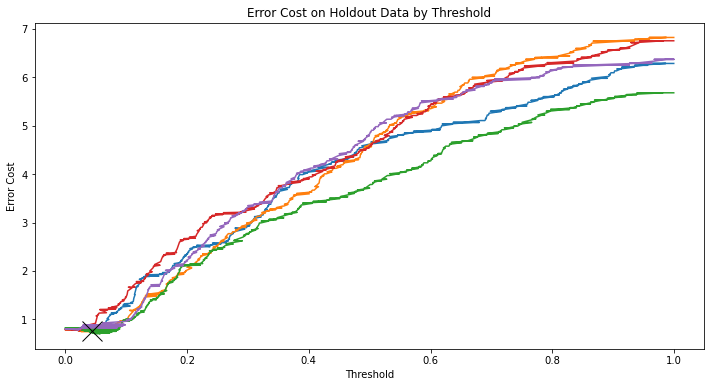

In [37]:
# Calculate empirical threshold with 5 folds
cutoff_cost_cv = lowest_error_cutoff(5, X_train, X_test, y_train, y_test, cost_matrix, pred_proba)

In [38]:
# Save confusion matrix for comparison later
cmat_CV = metrics.confusion_matrix(y_test, np.where(pred_proba >=  cutoff_cost_cv[0], 1, 0)) # compute corresponding confusion matrix

# Compare Bayes and CV-tuning

print("The cutoff and cost, respectively, for the Bayes model were: {}".format(cutoff_cost_bayes))
print("The cross-validated threshold tuning approach gave us the following cutoff and cost, respectively: {}".format(cutoff_cost_cv))

The cutoff and cost, respectively, for the Bayes model were: [0.0303, 0.76454]
The cross-validated threshold tuning approach gave us the following cutoff and cost, respectively: [0.045, 0.76286]


The cross-validated approach gave a slightly higher threshold for the optimal cutoff and a slightly lower error-cost. Since the model performs well on the test set,  we can see that the cutoff we found empirically also did not overfit. Due to the small difference in these numbers, there may be other factors which may lead a bank to choose a specific cutoff. For example, recall that our cost-matrix assumes 0 cost for correct predictions. Banks may also consider the benefits of correct predictions. For now, we can summarize that both approaches result in good cost performance in comparison to the default cutoff.

## Calibration curve (reliability plot)

To implement cutoff-based approaches for cost-sensitivity, we need well calibrated probability predictions. Well calibrated probability predictions are ones for which the output of `model.predict_proba()` is such that among the samples to which it gave a prediction value close to 0.8, approximately 80% actually belong to the positive class. Generally, the diagonal shows whether or not the predictions are calibrated well. Lines below the diagonal imply an over-forcast, and lines below the diagonal an under-forcast (probabilities too small). 

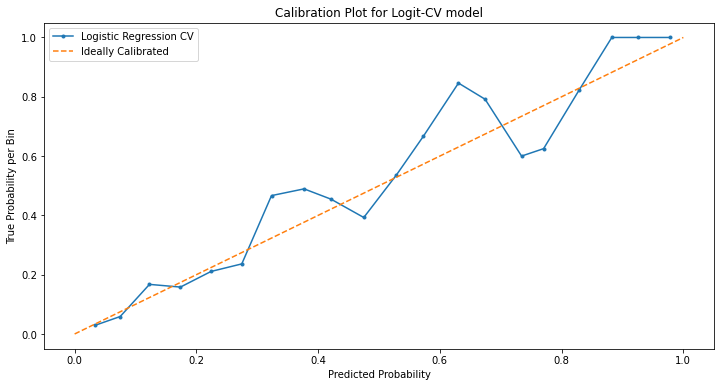

In [39]:
# Calibration curve for LogitCV
from sklearn.calibration import calibration_curve

# Calculate calibration using calibration_curve function
prob_true, prob_pred= calibration_curve(y_test, pred_proba, n_bins = 20)

# Plot results
plt.plot(prob_pred, prob_true, marker = '.', label = 'Logistic Regression CV')  
plt.title("Calibration Plot for Logit-CV model")
plt.ylabel("True Probability per Bin")
plt.xlabel("Predicted Probability") 
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated'); 
plt.legend();

In this plot we can see that the logit model outputs rather well-behaved (i.e., calibrated) probability predictions. This is important when we are concerned with setting the threshold. For a well-calibrated classifier, the Bayes-optimal cutoff should work well. This agrees with our above result. The Bayes-optimal and empirically tuned cut-off where reasonably close to one another. For other classifiers, the predicted probabilities may be far less calibrated. This might be the case for tree-based classifiers, for example. In such a case, we would expect the empirical approach toward finding a cut-off with minimal costs to work much better than calculating the Bayes-optimal cut-off. 

In the code cell below, generate a calibration curve for a tree model. How do you expect it to look? What influences the calibration of a tree model?

In [40]:
# Repeat this task for decision tree

## The MetaCost algorithm

Next we will discuss the MetaCost algorithm proposed by [Domingos (1999)](https://homes.cs.washington.edu/~pedrod/papers/kdd99.pdf). This method takes a different approach to making a model cost-sensitive. Similar to before, we do apply the Bayes minimal cutoff, but this time we use it to label our data. Basically, we train a model on the training set. We get the probability predictions for the test set for this model and apply the Bayes minimal cutoff to it. **We use this vector as our new y_train**, meaning we relabel the data. By using this cutoff, we want to achieve cost-sensitivity. For this first step it is important to use a model that is expected to give well-calibrated predictions. We then train any other model, on the data including the new labels and apply it to make predictions on the test set. Let's define this function:

In [41]:
def MetaCost(X_train, X_test, y_train, relabel_model, final_model, optimal_cutoff):
  # Use model with good calibration to predict the new labels and create probability predictions
  temp_pred_proba_train = relabel_model.fit(X_train, y_train.ravel()).predict_proba(X_train)[:,1]

  # Convert the probability predictions to class predictions using Bayes Decision Theory
  temp_pred_class_train = np.where(temp_pred_proba_train >= optimal_cutoff, 1, 0) # These are the new class labels

  # Fit a potent model to the test set, replacing our usual y_train with resulting class predictions from the last step
  final_model.fit(X_train, temp_pred_class_train.ravel())

  # Get predictions for the test set
  temp_pred_proba_test_cs = final_model.predict_proba(X_test)[:,1]

  return temp_pred_proba_test_cs

In [42]:
# Apply function 
pred_proba_MC = MetaCost(X_train, X_test, y_train, LogisticRegressionCV(), RandomForestClassifier(), threshold_bayes)

# Train model with original labels and predict the test set for comparison
pred_proba_RF = RandomForestClassifier().fit(X_train, y_train.ravel()).predict_proba(X_test)[:,1];

# Save corresponding confusion matrix for evaluation
cmat_MC = metrics.confusion_matrix(y_test, np.where(pred_proba_MC >=  0.5, 1, 0))

In [43]:
# Evaluate by calcuating the error-cost
cutoff_cost_MC = calc_error_cost(pred_proba_MC, y_test, 0.5, cost_matrix)
cutoff_cost_RF = calc_error_cost(pred_proba_RF, y_test, 0.5, cost_matrix)

print("The error-cost for the regular RF model is: {}".format(cutoff_cost_RF[1]))
print("The error-cost for the MetaCost approach is: {}".format(cutoff_cost_MC[1]))

The error-cost for the regular RF model is: 2.05705
The error-cost for the MetaCost approach is: 0.74609


By comparing the MetaCost approach to the regular RF model, we can see that this approach is indeed cost-sensitive and managed to reduce the cost to around 1/3 of the non cost-sensitive approach, giving us a similar result to the Bayes minimal risk approach. 

## Comparison of cost-sensitive methods
Before moving on to other libraries in Python covering the topic of cost-sensitivity, we want to compare the different cost-sensitive approaches by comparing their error cost.

In [44]:
# Summarize all cutoffs and error-costs in one DataFrame
cutoff_cost_df = pd.DataFrame([cutoff_cost_default, cutoff_cost_bayes, cutoff_cost_cv, cutoff_cost_MC], columns=["Cutoff", "Error-Cost"], index=['Default', 'Bayes', 'Cross-Validation', 'MetaCost'])
cutoff_cost_df

,Cutoff,Error-Cost
Default,0.5000,4.42897
Bayes,0.0303,0.76454
Cross-Validation,0.0450,0.76286
MetaCost,0.5000,0.74609


Firstly, by comparing all approaches to the default error cost by the LogitCV model, we can see that all approaches do make our models more cost efficient. We also see a slight improvement from the first to the last approach. However, as mentioned before, to identify the best model in terms of cost, other factors might be taken into consideration. 

Now, let's look the confusion matrix to get a better idea of the models.

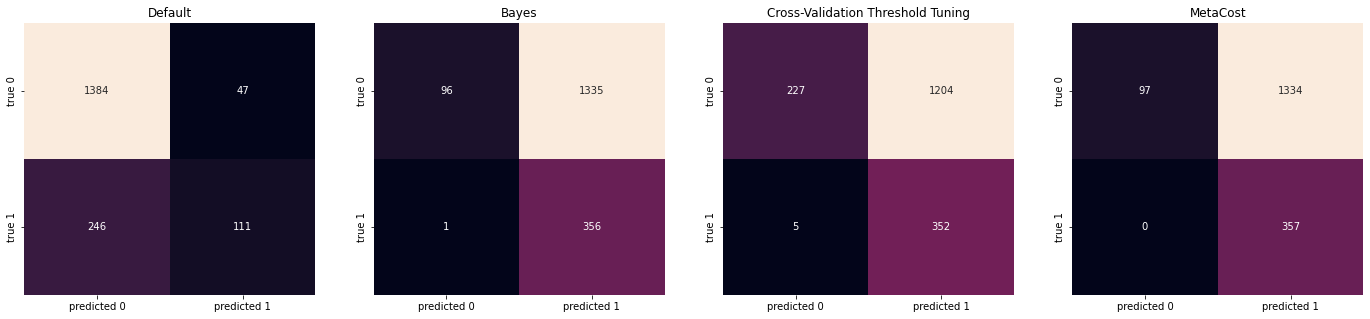

In [45]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (24, 5)

import seaborn as sns
fig, ax_lst = plt.subplots(1, 4)
cmat_list = [cmat_default, cmat_bayes, cmat_CV, cmat_MC]
csm_types = ["Default", "Bayes", "Cross-Validation Threshold Tuning", "MetaCost"] # types of cost-sensitive methods

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, xticklabels=['predicted 0', 'predicted 1'], yticklabels=['true 0', 'true 1'])
    
plt.show()


This plot shows that all cost-sensitive approaches were able to correctly identify all observations labelled with 1 (default) correctly. Therefore, in all of them, we can see a high increase in FN (top right). This means, the bank would reject more loan applications to trustworthy people. This also makes sense when you remember that all the cutoffs used for cutoff-based cost-sensitivity methods were very close to 0, meaning most cases would be classified as 1. It shows that for cost-sensitive scenarios, we may need to tolerate more misclassicationsto avoid a higher cost.

## Class imbalance and cost-sensitivity with `sklearn`

Now that we have seen some of how cost-sensitive learning works in the background, we can now begin using some of the built-in functionality of `sklearn` and other libraries. You'll notice that many `sklearn` functions have a built in `class_weight` argument that takes a dictionary in the form of `{class_label:weight, ...}`. Using this style, you can customize the weights of each class label to account for the cost of misclassifying a sample. You may also use the string `'balanced'` where class weights are calculated based on the imbalance of the classes. Furthermore, we can also define a dictionary with weights based on our cost matrix, to use the weights for cost-sensitive approaches. Below, we will illustrate both approaches, class imbalance and cost-sensitivity, using different models. Firstly, we will train unweighted models to use for comparison and get their predictions on the test set.


In [46]:
# Logistic Regression CV
clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True).fit(X_train, np.ravel(y_train))
y_pred_logcv_uw = clf.predict(X_test)
y_pred_proba_logcv_uw = clf.predict_proba(X_test)[:,1]

### Class imbalance
Let's first take a look at how adjusting weights in our model affects the quality of predictions using our traditional metrics (AUC and sensitivity). We will also check how often each class is predicted to see if this can help us explain the differences in our results.

For the first model which was the logit with cross-validation, we can see that adjusting `class_weight` helps us greatly improve the sensitivity of the model simply by using the `'balanced'` setting as the argument. The model predicted the minority class more often and not only did this raise sensitivity, it also raised the AUC. Overall, this shows us that this method was relatively successful.

In [47]:
# LogitCV Weighted vs. unweighted
acc = metrics.accuracy_score(y_test, y_pred_logcv_uw)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_logcv_uw, pos_label=1)
auc = metrics.auc(fpr, tpr)

print("The unweighted LogitCV model predicted the minority class {:.2f}".format(y_pred.sum()/len(y_pred)*100),"% of the time")
print("The AUC is {:.2f}".format(auc))
print("The sensitivity for the model is {:.2f}".format(tpr[1]))
print("")

# Fit a model with the regular data with balanced weights

clf = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True, class_weight='balanced').fit(X_train, np.ravel(y_train))
y_pred_cv_w = clf.predict(X_test) 
y_pred_proba_tree_w = clf.predict_proba(X_test)[:,1]
cutoff_cost_default = calc_error_cost(y_pred_proba_tree_w, y_test, 0.5, cost_matrix)

acc = metrics.accuracy_score(y_test, y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
auc = metrics.auc(fpr, tpr)

print("The weighted LogitCV model predicted the minority class {:.2f}".format(y_pred.sum()/len(y_pred)*100),"% of the time")
print("The AUC is {:.2f}".format(auc))
print("The sensitivity for the model is {:.2f}".format(tpr[1]))

The unweighted LogitCV model predicted the minority class 36.69 % of the time
The AUC is 0.64
The sensitivity for the model is 0.31

The weighted LogitCV model predicted the minority class 36.69 % of the time
The AUC is 0.71
The sensitivity for the model is 0.70


### Cost-Sensitivity

While class imbalance is directly built into the function, we will have to set the weights manually for making the models cost-sensitive. We will derive the weights from our cost-matrix. The weights we define are going to decide how much a missclassification is penalized. For misclassifying an observation of the class 0, we set the weight 1. The weight for incorrectly classifying an object of class 1 is 32, just like in our cost matrix. So let's go ahead with that:

In [48]:
# Define weights
weights = {0:1, 1:32}

In [49]:
# Error cost for weighted vs. unweighted LogitCV model
print('The error cost of the unweighted LogitCV model is: {}'.format(calc_error_cost(y_pred_proba_logcv_uw, y_test, 0.5, cost_matrix)[1]))

# Train model and get probabilities
y_pred_proba = LogisticRegressionCV(cv=5, random_state=rnd_state, fit_intercept=True, class_weight=weights).fit(X_train, np.ravel(y_train)).predict_proba(X_test)[:,1]
print('The error cost of the weighted LogitCV model is: {}'.format(calc_error_cost(y_pred_proba, y_test, 0.5, cost_matrix)[1]))

The error cost of the unweighted LogitCV model is: 4.42897
The error cost of the weighted LogitCV model is: 0.75615


 These results look very similar to the ones obtained in the cost-sensitive chapter of this tutorial. It shows that this is also an effective method to make your models cost-sensitive.

# Conclusions

It will likely be very common in your work that you will have two classes with either a large imbalance problem or a significant cost differences in misclassification. This tutorial should have provided you with some of the current ways of addressing this problem. For class imbalance, you could use random undersampling, oversampling or a more complex algorithm like SMOTE. For cost-imbalanced tasks, we have discussed different ways of either threshold tuning, the MetaCost algorithm and class weights. Below, we have summarized some of the functions we used today. 

# Overview table

| Goal | Possible Code |
| --- | --- |
| Fit logit with 5 fold CV | `LogisticRegressionCV(cv=5).fit(X_train, y_train)` |
| Get accuracy score of model | `metrics.accuracy_score(true_label, model_score))` |
| Get FPR, TPR and thresholds for AUC curve | `metrics.roc_curve(y_test, y_pred, pos_label=1)` |
| Use FPR and TPR from `roc_curve` | `metrics.auc(fpr, tpr)` |
| Initiate random undersampling object | `RandomUnderSampler( sampling_strategy='majority')` |
| Initiate random oversampling object | `RandomOverSampler(sampling_strategy='minority')` |
| Resample `X` and `y` using `sampler_obj`, assign to new `X` and `y` | `sampler_obj.fit_resample(X, y)` |
| Use SMOTE to resample `X` and `y` into new `X` and `y` | `SMOTE().fit_resample(X, y)` |
| Use BorderlineSMOTE to resample `X` and `y` into new `X` and `y`| `BorderlineSMOTE().fit_resample(X, y)` |
| Calculate error cost based on cost-matrix by Elkan| `(np.sum(np.sum((cmat/len(y_test))*cost_matrix.T))) ` |
| Calcualte calibration curve`| `calibration_curve(y_test, y_proba`) |
| Create heatmap chart | `sns.heatmap(data)` |
| Create confusion matrix of results | `confusion_matrix(y_true, y_pred)` |
| Create calibration curve for model | `calibration_curve(y_true, y_score)` |
| Create instance of 5-fold CV logit with weights | `LogisticRegressionCV(cv=5, class_weight={label:weight,...})` |
